# Transfer Learning using Keras and EfficientNet

**Author:** Serge Korzh, a data scientist at [Kiwee](https://kiwee.eu/)

In this notebook, we will train a classifier on the [Flowers image dataset](https://www.kaggle.com/olgabelitskaya/flower-color-images), but rather than building and training a [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional-neural-network) model from scratch, we'll use [Google's EfficientNet](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) model pre-trained on the [ImageNet dataset](http://www.image-net.org/) as a base. Essentially, this will transfer the knowledge accumulated during the training on a large image dataset with 1000 object classes to a similar, more specific problem – classifying flower images by species.

## Getting the dependencies

Let's first get the [efficientnet](https://github.com/qubvel/efficientnet) package that includes the model architecture.

In [1]:
!pip install efficientnet==1.1.0

     |████████████████████████████████| 50 kB 2.9 MB/s 


## Imports

In this notebook we'll need:
- `h5py` and `numpy` for data loading and manipulation
- `tensorflow`, `keras` and `efficientnet` for model training
- `matplotlib` for data visualisation. 

In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import the tensorflow.keras version of efficientnet
from efficientnet import tfkeras as efficientnet
import matplotlib.pyplot as plt

## Loading data

We'll use a very small dataset of flower photos [taken from Kaggle](https://www.kaggle.com/olgabelitskaya/flower-color-images). 
Run the following cell to load the data:

In [3]:
# when running on Colab, this will download the dataset and save into runtime first
import sys
if 'google.colab' in sys.modules:
    !wget https://github.com/KiweeEu/transfer-learning-demo/raw/master/data/flowers.h5 -P ./data

flowers_data = h5py.File('./data/flowers.h5', 'r')
images_data = flowers_data['images'][:]
labels_data = flowers_data['labels'][:]

--2021-08-21 11:25:09--  https://github.com/KiweeEu/transfer-learning-demo/raw/master/data/flowers.h5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/KiweeEu/transfer-learning-demo/master/data/flowers.h5 [following]
--2021-08-21 11:25:09--  https://raw.githubusercontent.com/KiweeEu/transfer-learning-demo/master/data/flowers.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10324178 (9.8M) [application/octet-stream]
Saving to: ‘./data/flowers.h5’

flowers.h5          100%[===================>]   9.85M  --.-KB/s    in 0.1s    

2021-08-21 11:25:10 (94.5 MB/s) - ‘./data/flowers.h5’ saved [10324178

It's a good habit to check how data looks like before actually starting to work with it.

Let's display basic information about the data to get a sense of what we're dealing with:

In [4]:
print(f'Images data shape: {images_data.shape}')
print(f'Labels data shape: {labels_data.shape}')
print(f'Images data min: {np.min(images_data)}, max: {np.max(images_data)}')
print(f'Images data type: {images_data.dtype}')
print(f'Labels data type: {labels_data.dtype}')
print(f'Unique labels: {np.unique(labels_data)}')
print(f'Number of unique labels: {len(np.unique(labels_data))}')

Images data shape: (210, 128, 128, 3)
Labels data shape: (210,)
Images data min: 0, max: 255
Images data type: uint8
Labels data type: uint8
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10


We have 210 images in total belonging to 10 classes, and each image is 128×128×3 (where 3 is the three primary color channels – Red, Green, Blue). Each pixel is an integer from 0 to 255. Also, notice that the class is stored as an integer from 0 to 9.

All of this is very important, especially when we use external frameworks and pre-trained models, we have to make sure our data is structured properly. We'll touch on that topic later in the notebook.

Let's also visualize a couple of images and the distribution of classes:

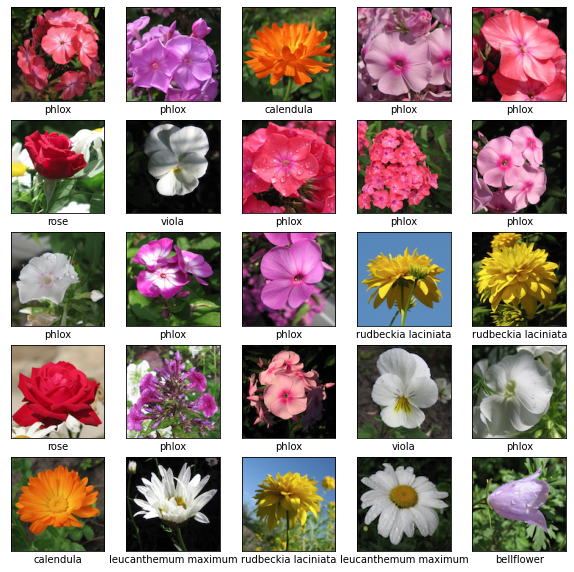

In [5]:
# Names of flower species are just for visualisation
flower_names = [
 'phlox','rose','calendula','iris','leucanthemum maximum',
    'bellflower','viola','rudbeckia laciniata','peony','aquilegia'
]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_data[i])
    plt.xlabel(flower_names[labels_data[i]])
plt.show()

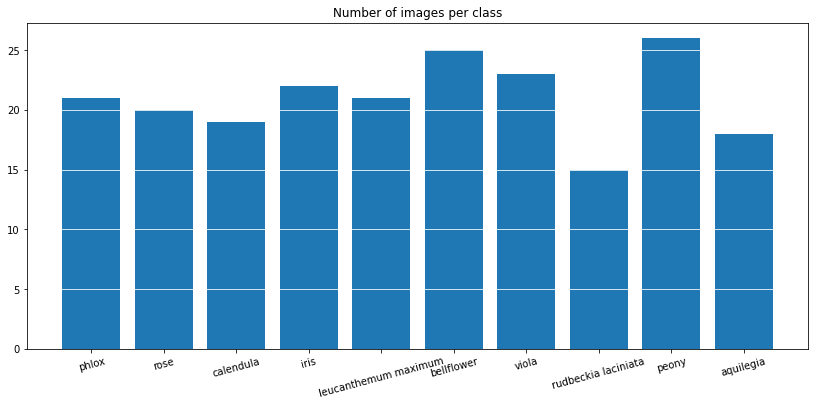

In [6]:
unique, counts = np.unique(labels_data, return_counts=True)
ticks = np.arange(len(counts))
plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, counts)
plt.xticks(ticks, flower_names, rotation=15)
plt.title('Number of images per class')
plt.show()

We can see that the dataset is more or less balanced – there aren't any classes that have substantially more or fewer examples than others.

Let's now shuffle the data and split it into two halves – one for training, and one for validation. Since we don't have a lot of data, let's split it equaly so that both training and in validation sets will have 105 images with ~10 images per class.

In [7]:
# Set a seed for reproducibility
seed = 1
def shuffle(a, b, seed=None):
    rand = np.random.RandomState(seed)
    p = rand.permutation(a.shape[0])
    return a[p], b[p]

x_data, y_data = shuffle(images_data, labels_data, seed=seed)

split_idx = int(0.5*x_data.shape[0])
x_train, y_train = x_data[:split_idx], y_data[:split_idx]
x_val, y_val = x_data[split_idx:], y_data[split_idx:]

Now, let's get to the nitty gritties of working with Keras. As we discussed, it's important to provide data to the model in the right format. We'll use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to do so. Let's go over its arguments:

1. `rotation_range`, `width_shift_range`, `height_shift_range`, `horizontal_flip` – those are augmentation parameters. Augmentation helps us introduce more variability from a small amount of data. Instead of feeding the original images, ImageDataGenerator will randomly apply transformations such as rotation (up to 20 degrees), shift along X and Y axes, and horizontal flipping (mirroring) of the image.
2. `data_format` – as you remember, the images have a format of 128×128×3 which corresponds to width×height×channels. The color channels are the last dimension. Thus we set the argument to `channels_last`.
3. `preprocessing_function` – since we use EfficientNet with pre-trained weights, it means the model has been already trained with images formatted in a certain way. Fortunately, efficientnet package provides `preprocess_input` function that will format the data in the same way it was formatted during training on the ImageNet data.

During validation, we don't want to alter the images because we want our model to perform well on the original ones. Thus, we'll create another ImageDataGenerator called `val_datagen` that omits augmentation.

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

After defining the generators, we need to specify from where to take the data. We do so using the `.flow(x, y)` method of the generators. It will return a [Python Iterator](https://docs.python.org/3/howto/functional.html#iterators) object that represents a stream of batches of the processed data.

In [9]:
train_iterator = train_datagen.flow(x_train, y_train, batch_size=35)
val_iterator = val_datagen.flow(x_val, y_val, batch_size=105)

## Model training

Okay, now to the exciting part – training our classifier! First, we have to define the model architecture, and for that, let's create the `get_model` function. It will receive two parameters: `input_shape` (i.e., dimensions of an image) and `num_classes` (i.e., the output shape). Inside, we'll create `base_model` using the `EfficientNetB4` function. This is one of eight different EfficientNet models ranging from `B0` to `B7` that differ by size. The bigger the model, the more capacity it has for learning, but it also requires more computing power and memory.

Let's go through the important arguments:
1. `weights='noisy-student'` – specifies that we want to use the weights trained on ImageNet data and a large amount of unlabelled data using the novel [Noisy Student training approach](https://arxiv.org/pdf/1911.04252v4.pdf) (see the paper for more info).
2. `pooling='avg'` - after passing the images through EfficientNet, the resulting values will be averaged by channel to form a single vector for each image.
3. `include_top=False` – the pre-trained model also includes the layer that gives predictions for ImageNet classes. We don't want that, as we'll train our own top layer to produce class probabilities for the ten flower species. Thus, we have to set `include_top` to `False`.

In [10]:
def get_model(input_shape, num_classes):
    base_model = efficientnet.EfficientNetB4(
        weights='noisy-student',
        pooling='avg',
        include_top=False,
        input_shape=input_shape
    )
    
    # "Freeze" the base_model layers so that we don't backpropagate through them.
    # This effectively makes base_model a feature extractor.
    for layer in base_model.layers:
        layer.trainable = False

    # Create our own fully-conected top layer with num_classes outputs that takes base_model.output as an input.
    # We use the 'softmax' activation for computing class probabilities.
    x = base_model.output
    predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

    # the Model class packages our architecture into one object
    model = keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

Let's now create the model. Running it for the first time might take some time, as has to download the weights. After that, we have to call `.compile()` on our model, specifying the following:
1. `optimizer='adam'` – specifies that we want to use Adam optimization during training. It is a popular variant of stochastic gradient descent that speeds up convergence.
2. `loss=keras.losses.sparse_categorical_crossentropy` – the loss function we want to use in this case is the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) used in categorical classification. It's called "sparse" since the true classes are specified as integers instead of as one-hot vectors.
3. `metrics=['accuracy']` – sets which metrics to track during training. 

In [11]:
model = get_model(input_shape=(128, 128, 3), num_classes=10)
model.compile(
    optimizer='adam',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

71688192/71678424 [==============================] - 2s 0us/step


Now, let's train the model by calling `.fit()`. All we need to pass is our iterator and the number of iterations (epochs).

In [12]:
model.fit(train_iterator, epochs=30)

Epoch 1/30
3/3 [==============================] - 17s 2s/step - loss: 2.5873 - accuracy: 0.1048
Epoch 2/30
3/3 [==============================] - 5s 2s/step - loss: 2.2231 - accuracy: 0.2095
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 1.9165 - accuracy: 0.4190
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 1.8242 - accuracy: 0.3905
Epoch 5/30
3/3 [==============================] - 5s 2s/step - loss: 1.6528 - accuracy: 0.4857
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 1.5200 - accuracy: 0.5333
Epoch 7/30
3/3 [==============================] - 5s 2s/step - loss: 1.4653 - accuracy: 0.5524
Epoch 8/30
3/3 [==============================] - 5s 2s/step - loss: 1.4334 - accuracy: 0.6000
Epoch 9/30
3/3 [==============================] - 5s 2s/step - loss: 1.2065 - accuracy: 0.6952
Epoch 10/30
3/3 [==============================] - 5s 2s/step - loss: 1.2334 - accuracy: 0.6857
Epoch 11/30
3/3 [==============================]

After training for 30 epochs, you should achieve a loss below 0.7 and accuracy above 80%. Now, let's test the model on our validation set by calling `.evaluate()`:

In [13]:
val_loss, val_acc = model.evaluate(val_iterator)
print(f'Validation loss: {round(val_loss, 4)}\nValidation accuracy: {round(val_acc*100, 4)}%')

1/1 [==============================] - 7s 7s/step - loss: 0.6460 - accuracy: 0.8571
Validation loss: 0.646
Validation accuracy: 85.7143%


On the validation set, you should get accuracy in the range of 75% to 95%. Such a big uncertainty comes from the fact that we have an extremely small dataset. In a real-world project, I highly recommend using [cross-validation](https://developers.google.com/machine-learning/glossary#cross-validation) to test your models in such cases to get an accurate perspective on the model's performance.

## Conclusion

Congrats! Having only 210 images from 10 classes, we achieved quite a high accuracy by leveraging the power of transfer learning. Hopefully, this notebook will serve you as a base for applying this technique in your future machine learning projects. Good Luck!

**P.S.** If you want to see a real-life example of how transfer learning can be used, check out our dog breed recognizer at [breedread.kiwee.eu](https://breedread.kiwee.eu/)